In [1]:
from plot_utils import plot_loss
from model import Model

In [2]:
train_val_split_ratio = 0.8
batch_size = 32
learning_rate = 0.00001
patience_early_stopping = 7
patience_reduce_learning_rate = 2
train_dir = "chest_xray/train"
test_dir = "chest_xray/test"
class_names = ["NORMAL", "PNEUMONIA"]

model = Model(learning_rate=learning_rate, batch_size=batch_size, patience_early_stopping=patience_early_stopping,
              patience_reduce_learning_rate=patience_reduce_learning_rate, train_dir=train_dir, test_dir=test_dir,
              class_names=class_names, train_val_split_ratio=train_val_split_ratio)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/michael/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:23<00:00, 2.00MB/s]


In [3]:
train_losses, val_losses = model.train_model(50)

Epoch 1/50, Train Loss: 0.534113394663463, Validation Loss: 1.0314839093974142, Learning Rate: 1e-05
Epoch 2/50, Train Loss: 0.5496861547755182, Validation Loss: 0.30618526161357074, Learning Rate: 1e-05
Epoch 3/50, Train Loss: 0.4973454455737553, Validation Loss: 1.177265373594833, Learning Rate: 1e-05
Epoch 4/50, Train Loss: 0.5143979193649328, Validation Loss: 0.4716497021490244, Learning Rate: 1e-05
Epoch 5/50, Train Loss: 0.4478621312770557, Validation Loss: 1.270383815873753, Learning Rate: 1e-05
Epoch 6/50, Train Loss: 0.5240106040831586, Validation Loss: 0.37570001398721203, Learning Rate: 1.0000000000000002e-06
Epoch 7/50, Train Loss: 0.5319386539618193, Validation Loss: 0.4043681106854682, Learning Rate: 1.0000000000000002e-06
Epoch 8/50, Train Loss: 0.31321282056882294, Validation Loss: 0.5663132022953394, Learning Rate: 1.0000000000000002e-06
Epoch 9/50, Train Loss: 0.457011902334261, Validation Loss: 0.5116110467210864, Learning Rate: 1.0000000000000002e-07
Early stopping 

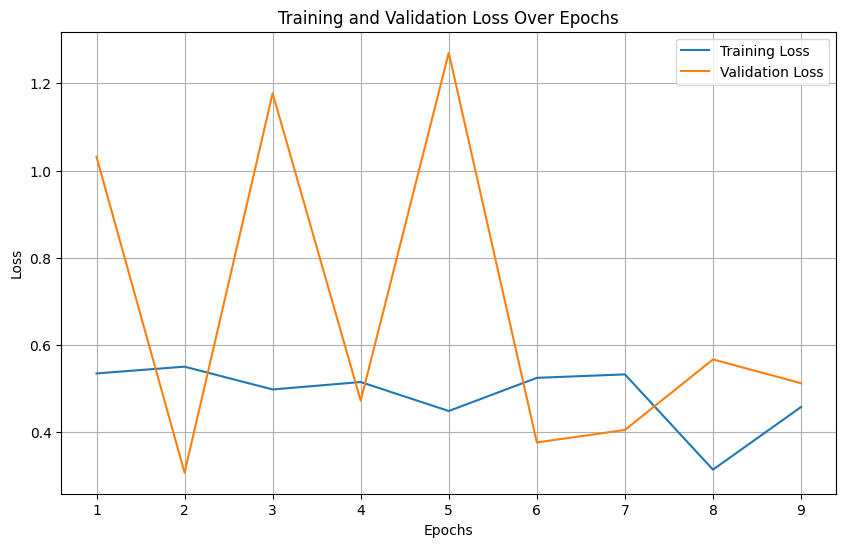

In [4]:
plot_loss(train_losses, val_losses)

In [5]:
model.evaluate()

Test Accuracy: 0.8317


([0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [6]:
import torch
torch.save(model.model.state_dict(), "model2.pth")